# 一元线性回归

基本形式
$$\tag{1}
f(\mathbf{x}) = w_1 x_1 + w_2 x_2 + ... + w_d x_d + b
$$
向量形式
$$\tag{2}
f(\mathbf{x}) = \mathbf{w}^\mathrm{T}\mathbf{x}+b
$$
其中$\mathbf{w} = (w_1; w_2; ...; w_d)$.

针对一元线性回归，我们有
$$\tag{3}
f(x) = w x + b$$

## 1. 读取数据
数据处理包括：数据分析、清理，数据集划分等

In [1]:
import numpy as np
import math

In [2]:
import pandas as pd

# 使用pandas读取csv数据
data = pd.read_csv('data/kaggle_house_price_prediction/kaggle_hourse_price_train.csv')
# 打印前5行
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# 丢弃有缺失值的特征（列）
data.dropna(axis = 1, inplace = True)

# 只保留整数的特征
data = data[[col for col in data.dtypes.index if data.dtypes[col] == 'int64']]
# 上下等价
idx_list = []
for col in data.dtypes.index:
    if data.dtypes[col] == 'int64':
        idx_list.append(col)
data = data[idx_list]


本题的要求是，针对LotArea, BsmtUnfSF, GarageArea三个特征，使用训练集训练三个一元线性回归模型，对比其在测试集上的MAE和RMSE，并且要绘制曲线。

所以我们只保留这三列与标记这一列，总共四列的数据即可

In [4]:
# 地块尺寸 未完成的地下室平方英尺 车库的面积
features = ['LotArea', 'BsmtUnfSF', 'GarageArea']
target = 'SalePrice'
data = data[features + [target]]
data.head()

,LotArea,BsmtUnfSF,GarageArea,SalePrice
0,8450,150,548,208500
1,9600,284,460,181500
2,11250,434,608,223500
3,9550,540,642,140000
4,14260,490,836,250000


## 2. 打乱数据顺序

In [5]:
from sklearn.utils import shuffle

In [6]:
data_shuffled = shuffle(data, random_state = 32) # 这个32不要改变

In [7]:
data_shuffled.head()

,LotArea,BsmtUnfSF,GarageArea,SalePrice
363,1680,321,264,118000
529,32668,816,484,200624
1394,4045,286,648,246578
803,13891,1734,1020,582933
832,9548,458,613,237000


## 3. 取前70%的数据为训练集，后30%为测试集

In [8]:
num_of_samples = data_shuffled.shape[0]
split_line = int(num_of_samples * 0.7)
train_data = data.iloc[:split_line]
test_data = data.iloc[split_line:]
data.shape

(1460, 4)

In [9]:
type(train_data)

pandas.core.frame.DataFrame

In [10]:
train_data.shape

(1021, 4)

In [11]:
test_data.shape

(439, 4)

## 4. 编写模型

我们以类(class)的形式编写这个模型，python中的类很简单，只不过这个类里面需要调用两个函数，一个是get_w，这个是计算模型w的函数，另一个是get_b，计算模型b的函数，需要大家来完成。

本实验要求使用最小二乘法求解一元线性回归模型  
求解$w$和$b$使均方误差$E_{(w,b)} = \sum^m_{i=1}(y_i - wx_i - b)^2$最小化的过程，称为线性回归模型的最小二乘“参数估计”(parameter estimation)。我们可将$E_{(w,b)}$分别对$w$和$b$求导，得到
$$\tag{4}
\frac{\partial E_{(w,b)}}{\partial w} = 2(w \sum^m_{i=1} x^2_i - \sum^m_{i=1} (y_i - b) x_i),
$$

$$\tag{5}
\frac{\partial E_{(w,b)}}{\partial b} = 2(mb - \sum^m_{i=1}(y_i - w x_i))
$$

然后令式(4)和式(5)为0，可得到$w$和$b$的闭式解(closed-form solution)
$$\tag{6}
w = \frac{\sum^m_{i=1} y_i(x_i - \bar{x})}{\sum^m_{i=1}x^2_i - \frac{1}{m}(\sum^m_{i=1}x_i)^2}
$$

$$\tag{7}
b = \frac{1}{m}\sum^m_{i=1}(y_i - w x_i)
$$
其中，$\bar{x} = \frac{1}{m}\sum^m_{i=1}x_i$为$x$的均值

首先编写求解w的函数，传入的参数就是x和y，都是np.ndarray类型的，或是pd.Series类型的（其实都一样）。我们需要大家在下面完成式(6)和式(7)的求解过程，将计算得到的w和b的值返回

In [12]:
def get_w(x, y):
    '''
    这个函数是计算模型w的值的函数，
    传入的参数分别是x和y，表示数据与标记
    
    Parameter
    ----------
        x: np.ndarray，pd.Series，传入的特征数据

        y: np.ndarray, pd.Series，对应的标记
    
    Returns
    ----------
        w: float, 模型w的值
    '''
    
    
    # m表示样本的数量
    m = train_data.shape[0]
    
    # 求x的均值
    x_mean = x.sum() / m

    # print(x.shape)
    # print(y.shape)
    
    # 求w的分子部分
    
    # numerator = 0.0
    # for i in range(m):
    #    numerator+=y[i]*(x[i]-x_mean)
    numerator=np.sum(y*(x-x_mean))
    
    
    # 求w的分母部分
    denominator = (x**2).sum() - (x.sum())**2 / m
    
    # 求w
    w = numerator/denominator
    
    # 返回w
    return w

In [13]:
def get_b(x, y, w):
    '''
    这个函数是计算模型b的值的函数，
    传入的参数分别是x, y, w，表示数据，标记以及模型的w值
    
    Parameter
    ----------
        x: np.ndarray，pd.Series，传入的特征数据

        y: np.ndarray, pd.Series，对应的标记
        
        w: np.ndarray, pd.Series，模型w的值
    
    Returns
    ----------
        b: float, 模型b的值
    '''
    # 样本个数
    m = train_data.shape[0]
    # x,y,w都是一维向量
    #print(x.shape)
    #print(y.shape)
    #print(w.shape)    
    
    # 求b
#    for i in range(m):
#        b += y[i]-w*x[i]
    b=(np.sum(y-w*x))/m     
    # 返回b
    return b

下面这个类，就是一个最简单的一元线性回归的类，我们已经帮你实现好了三个方法

In [14]:
class myLinearRegression:
    def __init__(self):
        '''
        参数
        这里设置了两个成员变量，用来存储模型w和b的值
        '''
        self.w = None
        self.b = None
    
    def fit(self,x, y):
        '''
        这里需要编写训练的函数，也就是调用模型的fit方法，传入特征x的数据和标记y的数据
        这个方法就可以求解出w和b
        '''
        self.w = get_w(x, y)
        self.b = get_b(x, y, self.w)
        
    def predict(self, x):
        '''
        这是预测的函数，传入特征的数据，返回模型预测的结果
        '''
        if self.w == None or self.b == None:
            print("模型还未训练，请先调用fit方法训练")
            return 
        
        
        return self.w * x + self.b


## 5. 预测

In [15]:
# 创建一个模型的实例
model1 = myLinearRegression()

# 使用训练集对模型进行训练，传入训练集的LotArea和标记SalePrice
model1.fit(train_data['LotArea'], train_data['SalePrice'])


# 对测试集进行预测，并将结果存储在变量prediction中
prediction1 = model1.predict(test_data['LotArea'])

## 6. 性能度量

模型训练完成后，还需要在测试集上验证其预测能力，这就需要计算模型的一些性能指标，如MAE和RMSE等。

$$\tag{8}
MAE(\hat{y}, y) = \frac{1}{m} \sum^m_{i=1} \vert \hat{y} - y \vert
$$

$$\tag{9}
RMSE(\hat{y}, y) = \sqrt{\frac{1}{m} \sum^m_{i=1} (\hat{y} - y)^2}
$$
其中，$\hat{y}$是模型的预测值，$y$是真值，$m$是样本数

In [16]:
def MAE(y_hat, y): 
    # 请你完成MAE的计算过程
    # YOUR CODE HERE
    m=train_data.shape[0] 
    result = abs(y_hat-y).sum()/m
    
    return result

In [17]:
def RMSE(y_hat, y):
    # 请你完成RMSE的计算过程
    # YOUR CODE HERE
    m=train_data.shape[0] 
    return math.sqrt( ((y_hat-y)**2).sum()/m  )

在此计算出模型在测试集上的MAE与RMSE值

In [18]:
mae1 = MAE(prediction1, test_data['SalePrice'])
rmse1 = RMSE(prediction1, test_data['SalePrice'])
print("模型1，特征：LotArea")
print("MAE:", mae1)
print("RMSE:", rmse1)

模型1，特征：LotArea
MAE: 23180.929269211123
RMSE: 49700.822284572925


## 7. 模型预测效果可视化

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

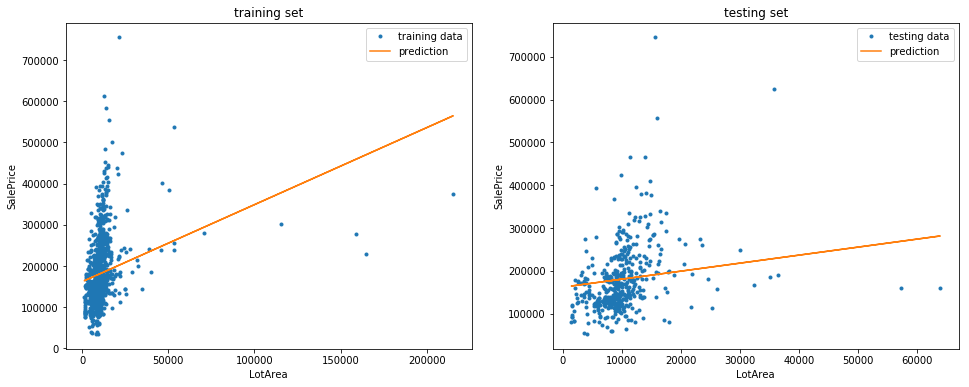

In [23]:
# 创建新的图
plt.figure(figsize = (16, 6))

# 创建子图1
plt.subplot(121) # 121分别代表，生成1行2列个图，这是第1个

#plt.xlim(0,50000)  #只显示x在区间[0,50000]的部分

# 其中的参数为横轴值，纵轴值，label为此条曲线的标签， '.' 表示画出的图的图形为散点图
plt.plot(train_data['LotArea'].values, train_data['SalePrice'].values, '.', label = 'training data')
# '-' 表示画出的图形为折线图
plt.plot(train_data['LotArea'].values, model1.predict(train_data['LotArea']), '-', label = 'prediction')
plt.xlabel("LotArea")
plt.ylabel('SalePrice')
plt.title("training set")
plt.legend()

# 创建子图2
plt.subplot(122) # 121分别代表，生成1行2列个图，这是第2个
plt.plot(test_data['LotArea'].values, test_data['SalePrice'].values, '.', label = 'testing data')
plt.plot(test_data['LotArea'].values, prediction1, '-', label = 'prediction')
plt.xlabel("LotArea")
plt.ylabel('SalePrice')
plt.title("testing set")
plt.legend()

### 通过左右两图的对比，分析该模型出现的问题，并给出能帮助模型更好的做预测的方案(选做)
###### 双击此处展开讨论

### 讨论：

### 训练集中含有许多异常值或离群值，可以在数据处理阶段把这些点删除，可以有效提高数据质量，获得更好的线性模型。实现部分在最后


# 使用BsmtUnfSF作为特征，完成模型的训练，指标计算，可视化

In [24]:
# YOUR CODE HERE

# 创建一个模型的实例
model2 = myLinearRegression()

# 使用训练集对模型进行训练，传入训练集的LotArea和标记SalePrice
model2.fit(train_data['BsmtUnfSF'], train_data['SalePrice'])


# 对测试集进行预测，并将结果存储在变量prediction中
prediction2 = model2.predict(test_data['BsmtUnfSF'])


In [25]:
# 计算模型在测试级上的MAE和RMSE值
mae2=MAE(prediction2,test_data['SalePrice'])
rmse2=RMSE(prediction2,test_data['SalePrice'])
print("模型2,特征：BsmtUnfSF")
print("MAE:",mae2)
print("RMSE:",rmse2)

模型2,特征：BsmtUnfSF
MAE: 23194.739127797686
RMSE: 50422.269358649624


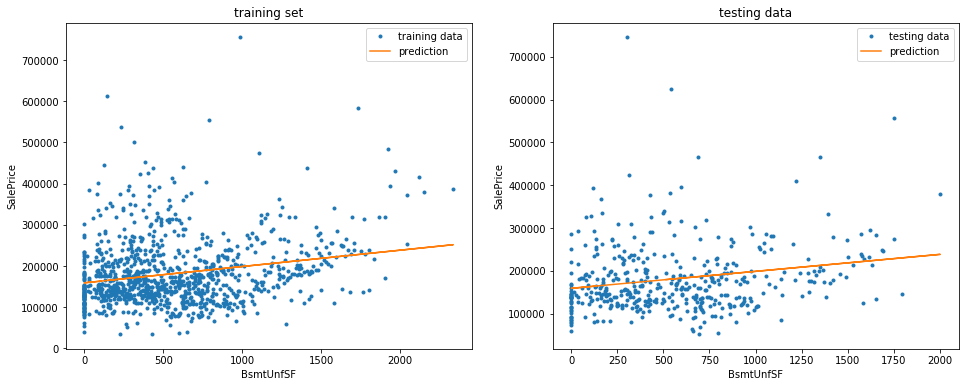

In [26]:
#创建新的图
plt.figure(figsize=(16,6) )

plt.subplot(121)
#plt.xlim(0,50000)
plt.plot(train_data['BsmtUnfSF'].values,train_data['SalePrice'].values,'.',label="training data")
plt.plot(train_data['BsmtUnfSF'].values,model2.predict(train_data['BsmtUnfSF']),'-',label='prediction')

plt.xlabel("BsmtUnfSF")
plt.ylabel("SalePrice")
plt.title("training set")
plt.legend()

#创建子图2
plt.subplot(122)
plt.plot(test_data["BsmtUnfSF"].values,test_data["SalePrice"].values,".",label="testing data")
plt.plot(test_data["BsmtUnfSF"].values,prediction2,'-',label="prediction")

plt.xlabel("BsmtUnfSF")
plt.ylabel("SalePrice")
plt.title("testing data")
plt.legend()

# 使用GarageArea作为特征，完成模型的训练，指标计算，可视化

In [30]:
# YOUR CODE HERE

# 创建一个模型的实例
model3 = myLinearRegression()

# 使用训练集对模型进行训练，传入训练集的LotArea和标记SalePrice
model3.fit(train_data['GarageArea'], train_data['SalePrice'])


# 对测试集进行预测，并将结果存储在变量prediction中
prediction3 = model3.predict(test_data['GarageArea'])


In [31]:
# 计算模型在测试级上的MAE和RMSE值
mae3=MAE(prediction3,test_data['SalePrice'])
rmse3=RMSE(prediction3,test_data['SalePrice'])
print("模型3,特征：GatageArea")
print("MAE:",mae3)
print("RMSE:",rmse3)

模型3,特征：GatageArea
MAE: 18516.5287697436
RMSE: 42888.17479186363


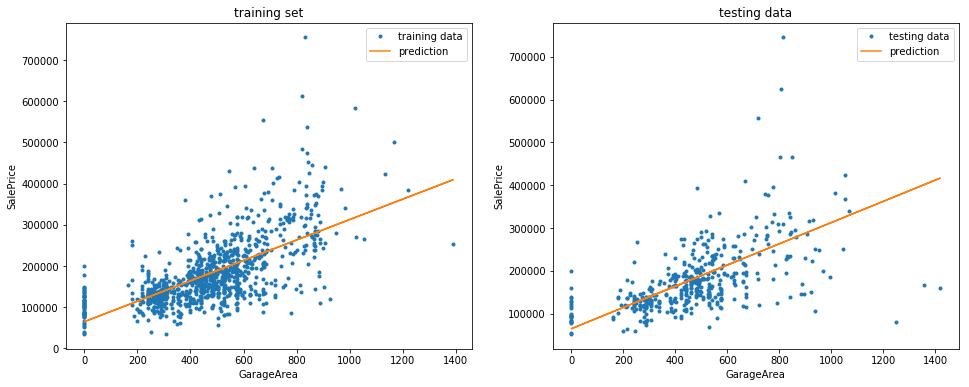

In [32]:
#创建新的图
plt.figure(figsize=(16,6) )

plt.subplot(121)
#plt.xlim(0,50000)
plt.plot(train_data['GarageArea'].values,train_data['SalePrice'].values,'.',label="training data")
plt.plot(train_data['GarageArea'].values,model3.predict(train_data['GarageArea']),'-',label='prediction')

plt.xlabel("GarageArea")
plt.ylabel("SalePrice")
plt.title("training set")
plt.legend()

#创建子图2
plt.subplot(122)
plt.plot(test_data["GarageArea"].values,test_data["SalePrice"].values,".",label="testing data")
plt.plot(test_data["GarageArea"].values,prediction3,'-',label="prediction")

plt.xlabel("GarageArea")
plt.ylabel("SalePrice")
plt.title("testing data")
plt.legend()

# 选做：剔除训练集中的离群值(outlier)，然后重新训练模型，观察模型预测性能的变化
###### 提示：可以使用下面的代码处理数据
###### 如果没有剔除数据集中的离群值，将会影响平均值的可靠性

模型2,特征：LotArea
MAE: 22428.012175977245
RMSE: 49358.80519162922


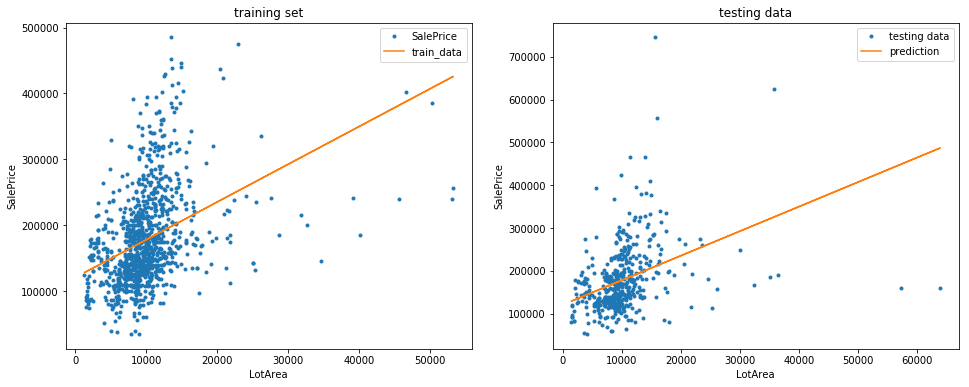

In [33]:
# YOUR CODE HERE
t = train_data[(train_data['LotArea'] < 60000) & (train_data['LotArea'] > 0)] # 将训练集中LotArea小于60000的值存入t
t = t[t['SalePrice'] < 500000] # 将t中SalePrice小于500000的值保留

# 创建一个模型的实例
model2 = myLinearRegression()

# 使用训练集对模型进行训练，传入训练集的LotArea和标记SalePrice
model2.fit(t['LotArea'], t['SalePrice'])


# 对测试集进行预测，并将结果存储在变量prediction中
prediction2 = model2.predict(test_data['LotArea'])

# 计算模型在测试级上的MAE和RMSE值
mae2=MAE(prediction2,test_data['SalePrice'])
rmse2=RMSE(prediction2,test_data['SalePrice'])
print("模型2,特征：LotArea")

print("MAE:",mae2)
print("RMSE:",rmse2)

# 绘制处理后的数据

plt.figure(figsize=(16,6) )
plt.subplot(121)
#plt.xlim(0,50000)
plt.plot(t['LotArea'], t['SalePrice'], '.')
plt.plot(t['LotArea'].values,model2.predict(t['LotArea']),'-',label="train_data")
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.title("training set")
plt.legend()

#创建子图2
plt.subplot(122)
plt.plot(test_data["LotArea"].values,test_data["SalePrice"].values,".",label="testing data")
plt.plot(test_data["LotArea"].values,prediction2,'-',label="prediction")

plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.title("testing data")
plt.legend()

In [34]:
# 除去一部分离群值之后，这些数据训练的模型在测试集上的误差mae，rmse均有所减小。

模型2,特征：LotArea
MAE: 23116.294112016174
RMSE: 52082.37701192053


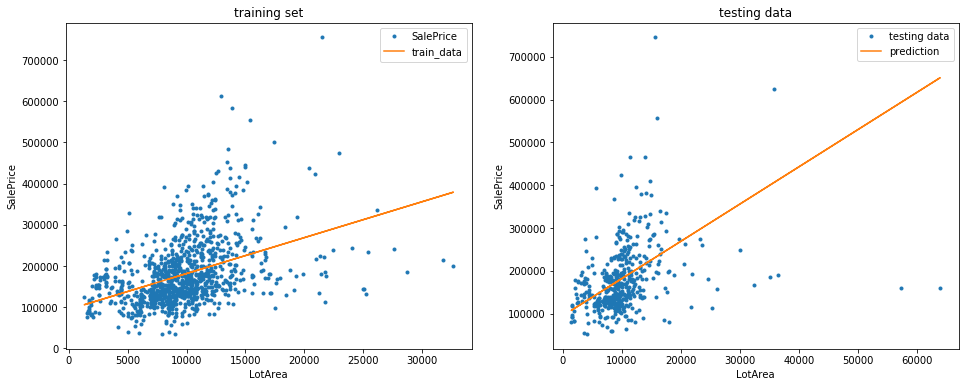

In [35]:

# 采用拉依达法来去除离群值：舍弃掉| x-x_mean | > 2*σ ；σ为数据的标准差
# 均值
x_mean = train_data['LotArea'].sum()/train_data.shape[0]
#标准差
x_std=train_data['LotArea'].std()
# 采用布尔代数
t=train_data[abs(train_data['LotArea']-x_mean)<2*x_std]
# 创建一个模型的实例
model2 = myLinearRegression()

# 使用训练集对模型进行训练，传入训练集的LotArea和标记SalePrice
model2.fit(t['LotArea'], t['SalePrice'])


# 对测试集进行预测，并将结果存储在变量prediction中
prediction2 = model2.predict(test_data['LotArea'])

# 计算模型在测试级上的MAE和RMSE值
mae2=MAE(prediction2,test_data['SalePrice'])
rmse2=RMSE(prediction2,test_data['SalePrice'])
print("模型2,特征：LotArea")

print("MAE:",mae2)
print("RMSE:",rmse2)

# 绘制处理后的数据

plt.figure(figsize=(16,6) )
plt.subplot(121)
#plt.xlim(0,50000)
plt.plot(t['LotArea'], t['SalePrice'], '.')
plt.plot(t['LotArea'].values,model2.predict(t['LotArea']),'-',label="train_data")
plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.title("training set")
plt.legend()

#创建子图2
plt.subplot(122)
plt.plot(test_data["LotArea"].values,test_data["SalePrice"].values,".",label="testing data")
plt.plot(test_data["LotArea"].values,prediction2,'-',label="prediction")

plt.xlabel("LotArea")
plt.ylabel("SalePrice")
plt.title("testing data")
plt.legend()

###  总结：通过标准差这种方法不是特别的靠谱，因为离群值的出现可能反过来很大程度影响平均数和标准差，所以平均数或者标准差受离群值的制约而使得这个检测方法不靠谱；把训练集上的离群值删除掉之后，测试集上也有离群值。
###  